In [1]:
import fastai
from fastai.vision.all import *
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import cv2

In [2]:
URLs.MNIST
root_path = untar_data(URLs.MNIST)
task_path = root_path
train_path = root_path

In [3]:
btfms = aug_transforms()+[Normalize.from_stats(*mnist_stats)]

In [4]:
def image2image(x):
    return x

In [34]:
block = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                  get_items = get_image_files,
                  get_y = image2image,
                  splitter=RandomSplitter(0.1),                  
                  item_tfms=Resize(32),
                  batch_tfms = btfms,
)

In [ ]:
dls = block.dataloaders(train_path, batch_size=128)

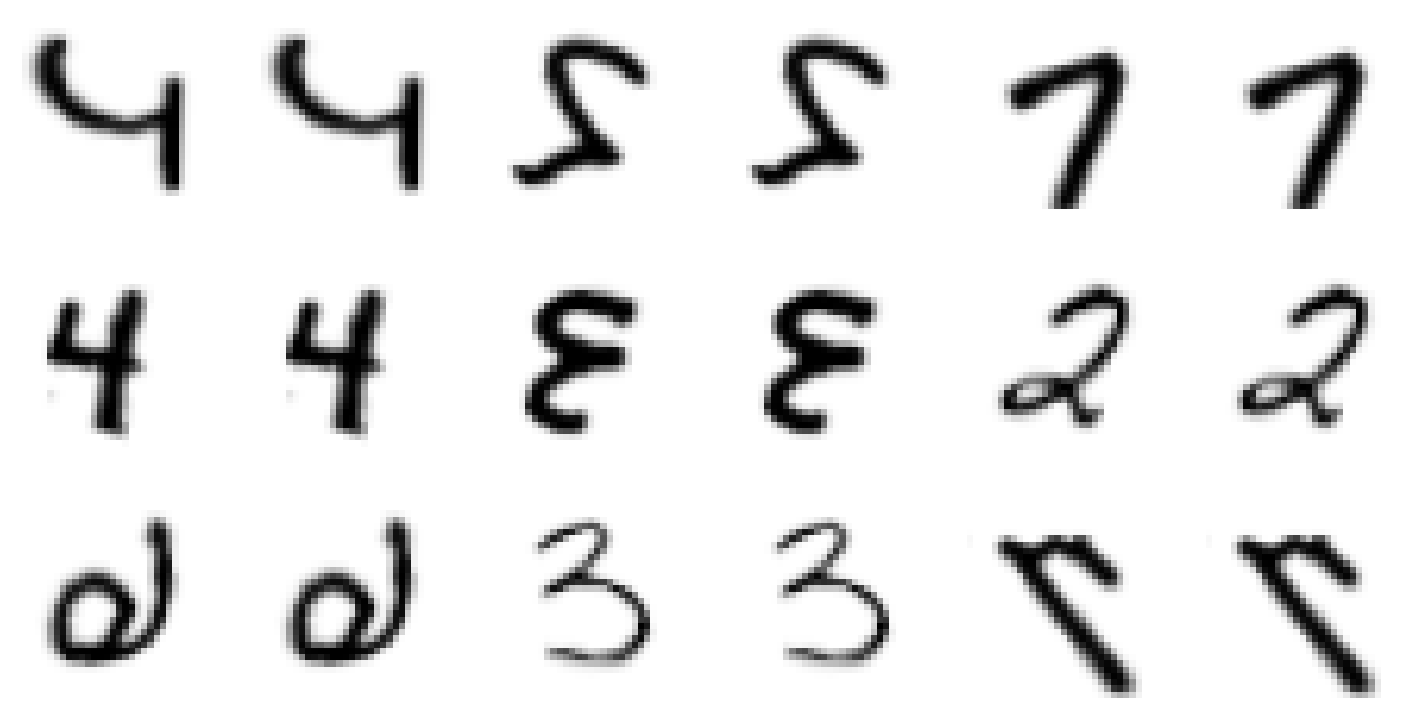

In [54]:
dls.show_batch(max_n=9)

In [55]:
arch = create_body(resnet18(), n_in=1).cuda()

In [56]:
class UpsampleBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, leaky:float=None, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, **kwargs)
        self.conv2 = ConvLayer(nf, nf, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return self.conv2(self.conv1(cat_x))

In [57]:
def decoder_resnet(y_range, n_out=1):
    return nn.Sequential(UpsampleBlock(512), 
                         UpsampleBlock(256),
                         UpsampleBlock(128),
                         UpsampleBlock(64),
                         UpsampleBlock(32),
                         nn.Conv2d(16, n_out, 1),
                         SigmoidRange(*y_range)
                        )
                         
def autoencoder(encoder, y_range): return nn.Sequential(encoder, decoder_resnet(y_range))

In [58]:
y_range = (-3.,3.)
ac_resnet = autoencoder(arch, y_range).cuda()

In [59]:
dec = decoder_resnet(y_range).cuda()

In [60]:
learn = Learner(dls, ac_resnet, loss_func=MSELossFlat())

In [61]:
learn.unfreeze()

In [62]:
x,y = learn.dls.one_batch()

In [63]:
y.shape

torch.Size([128, 1, 32, 32])

In [64]:
x.shape

torch.Size([128, 1, 32, 32])

In [65]:
learn.predict(learn.dls.train_ds[0][0])[0].shape

torch.Size([1, 32, 32])

In [68]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

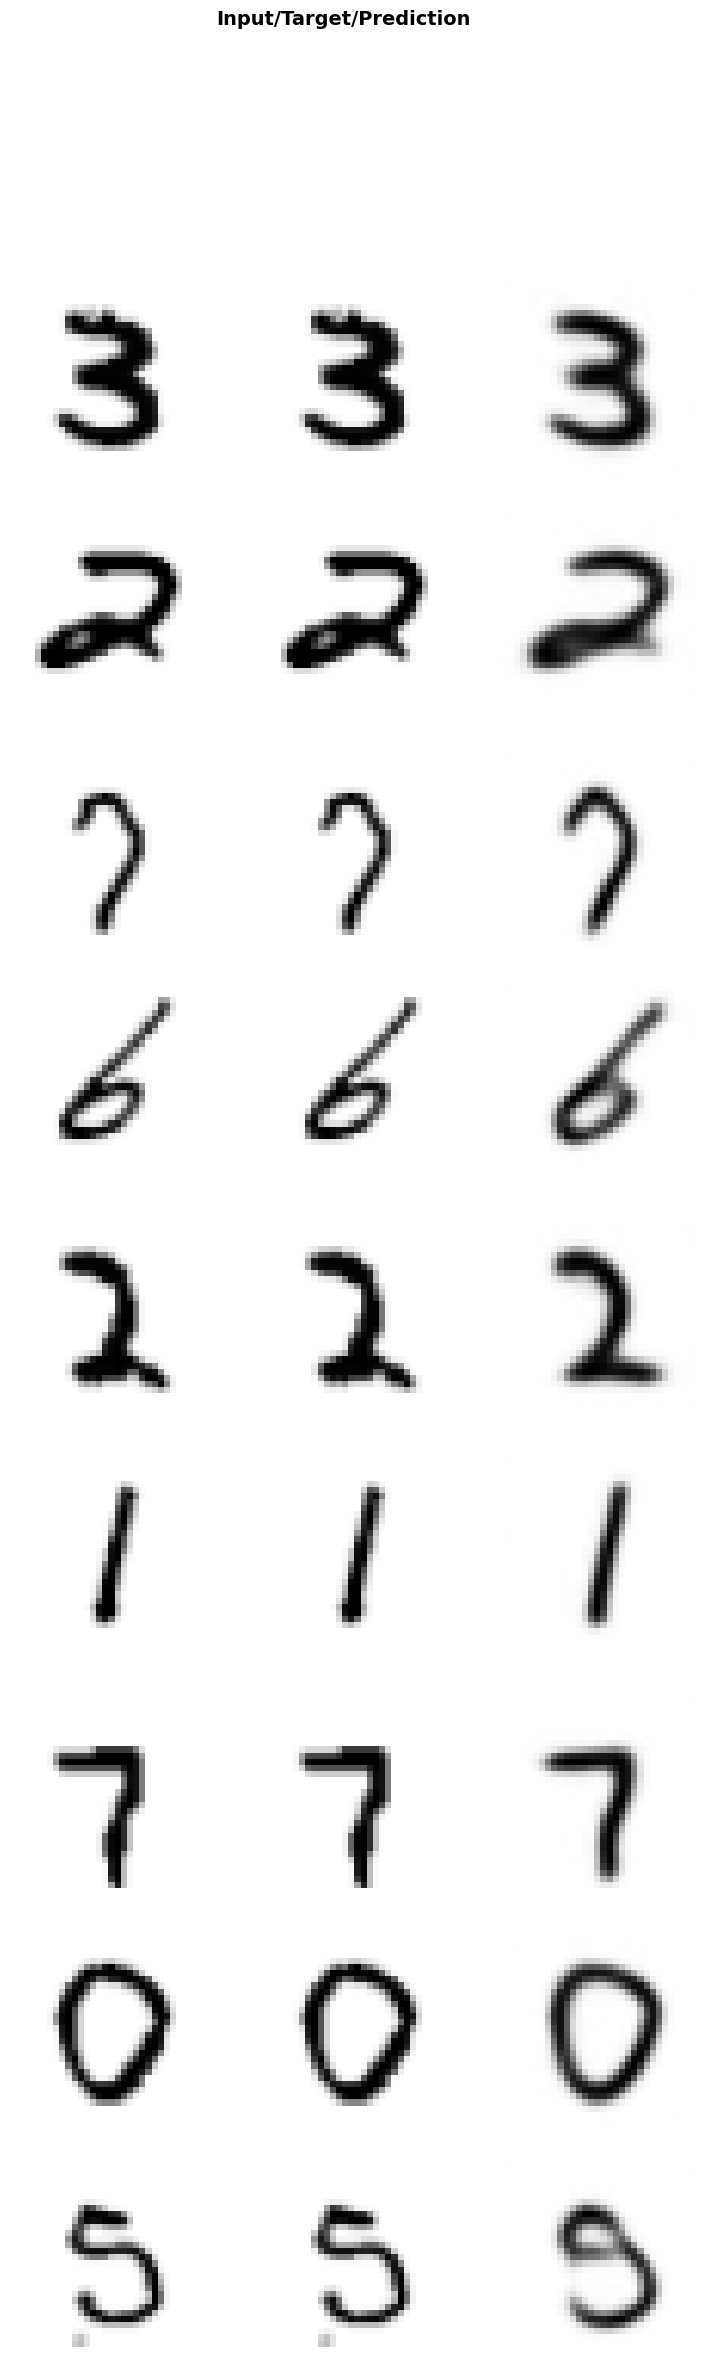

In [49]:
learn.show_results()

In [50]:
learn.save("resent_18_stage_1")

Path('models/resent_18_stage_1.pth')

In [51]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.084348,0.088633,01:03
1,0.091461,0.094150,01:04
2,0.077462,0.078208,01:00
3,0.066613,0.076418,00:59
4,0.056895,0.057089,00:58
5,0.049870,0.052030,01:01
6,0.043001,0.041958,01:03
7,0.038366,0.038070,01:00
8,0.036230,0.035706,01:02
9,0.034903,0.034977,01:01


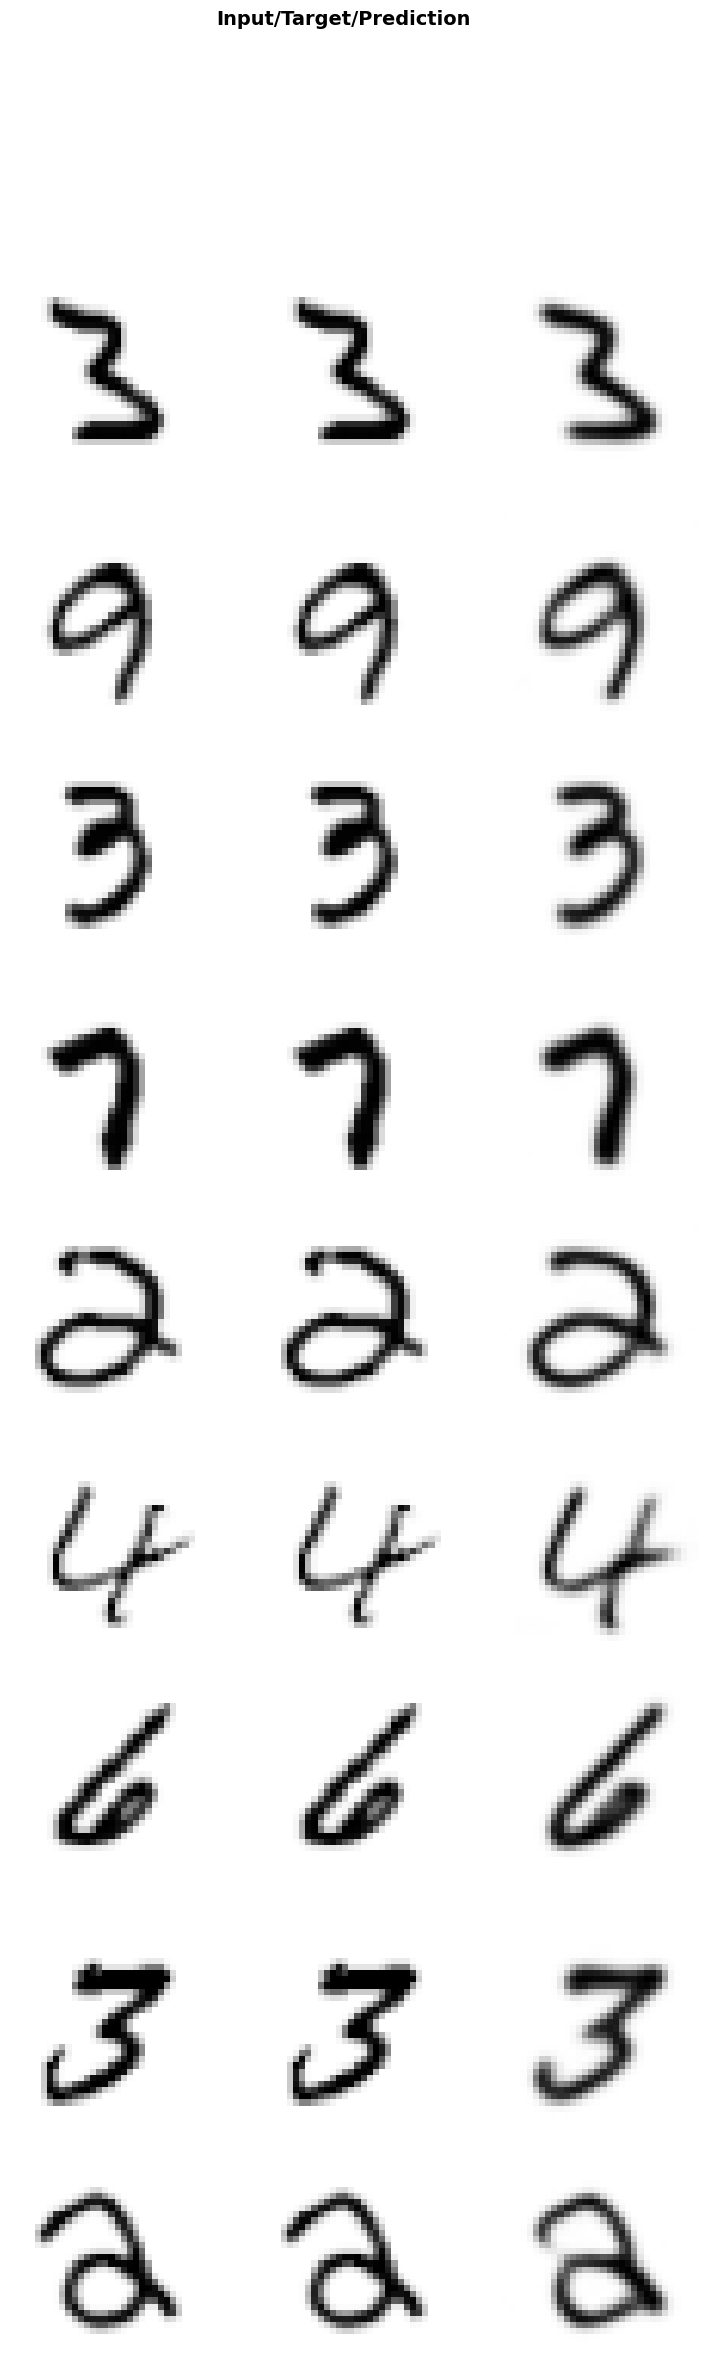

In [52]:
learn.show_results()

In [ ]:
learn.save("resent_18_stage_32_2")

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6,1e-4))

In [ ]:
learn.show_results()

In [ ]:
learn.save("resent_18_stage_3")

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, slice(1e-5,1e-3))

In [ ]:
learn.show_results()

In [ ]:
learn.save("resent_18_stage_4")

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(20,slice(1e-5,1e-4))

In [ ]:
learn.show_results()

In [ ]:
learn.save("resent_18_stage_5")

In [ ]:
learn.fit_one_cycle(200, slice(1e-5,1e-3))

In [ ]:
learn.show_results()

In [ ]:
learn.save("resent_18_stage_6")

In [ ]:
def get_image(filename):
    image = Image.open(filename)
    image = image.resize((256,256))
    image = np.array(image)
    image = PILImage.create(image)
    image = TensorImage(image).permute(2,0,1)
    return image

Test mit Fehler

In [ ]:
image = get_image(task_path/"test"/"poke"/"001.png")
predicted = learn.predict(image)[0]

heatmap = np.sum(np.absolute(np.array(predicted - image)),axis=0)
mask =  heatmap > heatmap.max()*0.5

plt.imshow(mask)

contours, hierarchy = cv2.findContours(image=mask.astype(np.uint8), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)    
f,axes = plt.subplots(ncols=3,nrows=1,figsize=(20,8))
axes[0].imshow(image.permute(1,2,0), cmap="gray")
axes[1].imshow(predicted.permute(1,2,0), cmap="gray")

axes[2].imshow(image.permute(1,2,0), cmap="gray")
for cont in contours:
    if len(cont) == 1:
        continue
    cont = np.squeeze(cont)    
    axes[2].plot(cont[:,0], cont[:,1], "r-")
plt.show()

Test mit selbst eingefügtem Text

In [ ]:
learn.load("resent_18_stage_6")

In [ ]:
loss = MSELossFlat()

In [ ]:
good_test_images = get_image_files(task_path/"test", folders=["good"])
losses_good = []
for img_file in good_test_images:
    x = TensorImage(PILImage.create(np.array(Image.open(img_file).resize((512,512))))).permute(2,0,1)    
    y_hat = learn.predict(x)[0]    
    losses_good.append(np.absolute(np.array(y_hat - x)).mean())

In [ ]:
anomalie_images = get_image_files(task_path/"test", folders=["crack","cut","hole","print"])
losses_anomaly = []
for img_file in anomalie_images:
    x = TensorImage(PILImage.create(np.array(Image.open(img_file).resize((256,256))))).permute(2,0,1)    
    y_hat = learn.predict(x)[0]    
    losses_anomaly.append(np.absolute(np.array(y_hat - x)).mean())

In [ ]:

losses = []
for idx in range(len(dls.train_ds)):
    x,y = dls.do_item(idx)
    y_hat = learn.predict(x)[0]    
    losses.append(np.absolute(np.array(y_hat - y)).mean())

In [ ]:
plt.hist(losses, bins=100)
plt.hist(losses_anomaly, bins=100)
plt.hist(losses_good, bins=50)
plt.show()

In [ ]:
x = TensorImage(PILImage.create(np.array(Image.open(task_path/"test"/"hole"/"001.png").resize((256,256))))).permute(2,0,1)
y_hat = learn.predict(x)[0]
#np.absolute(np.array(y_hat - x)).mean()

In [ ]:
plt.imshow(x.permute(1,2,0))

In [ ]:
plt.imshow(y_hat.permute(1,2,0))

In [ ]:
masked_heatmap

In [ ]:
heatmap.max()

In [ ]:
plt.imshow(heatmap < heatmap.max()*0.5)

In [ ]:
heatmap = np.sum(np.absolute(np.array(y_hat - x)),axis=0)
kernel = np.ones((5, 5), 'uint8')
mask = heatmap > heatmap.max()*0.5
mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=6)
mask = cv2.erode(mask, kernel, iterations=6).astype(bool)

mask = np.ma.masked_where(mask==False, mask)


In [ ]:
mask.max()

In [ ]:
mask.astype(bool)

In [ ]:
plt.imshow(mask)

In [ ]:
masked_heatmap.mask.astype(np.uint8)

In [ ]:
masked_heatmap.mask = dilate_img.astype(bool)

In [ ]:
kernel = np.ones((5, 5), 'uint8')
dilate_img = cv2.erode(masked_heatmap.mask.astype(np.uint8), kernel, iterations=6)
dilate_img = cv2.dilate(dilate_img, kernel, iterations=6)

In [ ]:
plt.imshow(dilate_img.astype(bool))

In [ ]:
mask

In [ ]:
plt.imshow(x.permute(1,2,0))
#plt.imshow(masked_heatmap,  alpha=1.0)
plt.imshow(mask, alpha=0.6, cmap=cm.Greens_r)

In [ ]:
plt.imshow(np.absolute(np.array(y_hat - x))[0], cmap="gray")

In [ ]:
y_hat.shape, x.shape

In [ ]:
np.absolute(np.array(y_hat - y)).mean()

In [ ]:
y_hat.permute(1,2,0)

In [ ]:
plt.imshow(x.permute(1,2,0))

In [ ]:
plt.imshow(y_hat.permute(1,2,0))

In [ ]:
y_hat.

In [ ]:
plt.imshow(np.absolute(np.array(y_hat - x))[2], cmap="gray")

In [ ]:

for item in range(len(dls.train_ds)):
    dls.do_item(500)[0]

In [ ]:
learn.dls.train_ds[0][0].size

In [ ]:
np.squeeze(np.array(prediction[0])).astype(np.uint8)

In [ ]:
PILImageBW.create(np.squeeze(np.array(prediction[0])).astype(np.uint8))

In [ ]:
img = PILImage.create(np.array(Image.open(task_path/"test"/"hole"/"002.png").resize((512,512))))
prediction = learn.predict(img)
reconstructed_img = PILImageBW.create(np.squeeze(np.array(prediction[0])).astype(np.uint8))
loss = prediction[1]

In [ ]:
np.squeeze(np.array(prediction[0])).shape

In [ ]:
PILImage.create(prediction[0])

In [ ]:
len(learn.predict())

In [ ]:
TensorImage(img).size()

In [ ]:
loss(prediction[0].permute(1,2,0),TensorImage(img))

In [ ]:
x,y = learn.dls.one_batch()

In [ ]:
x.shape, y.shape

In [ ]:
x.shape

In [ ]:
y_hat = learn.model(x)

In [ ]:
loss(y_hat,y)

In [ ]:
learn.dls.

In [ ]:
learn.dls.create_item([img])

In [ ]:
img = PILImage.create(np.array(Image.open(task_path/"train"/"good"/"002.png").resize((512,512))))

In [ ]:
img = PILImage.create(np.array(Image.open(task_path/"train"/"good"/"002.png").resize((512,512))))
prediction = learn.predict(img)
loss_value = loss(prediction[0].permute(1,2,0),TensorImage(img))

In [ ]:
loss_value.item()

In [ ]:
img = PILImage.create(np.array(Image.open(task_path/"test"/"hole"/"000.png").resize((512,512))))
prediction = learn.predict(img)
reconstructed_img = PILImage.create(np.squeeze(np.array(prediction[0])).astype(np.uint8))
loss = torch.squeeze(prediction[1])

mask = np.zeros(img.size, dtype=bool)
for idx in [0,1,2]:
    treshold = loss[idx].max()*0.8
    mask = np.logical_or(mask, np.array(loss[idx] > treshold))

contours, hierarchy = cv2.findContours(image=mask.astype(np.uint8), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)    

f,axes = plt.subplots(ncols=3,nrows=1,figsize=(20,8))
axes[0].imshow(img, cmap="gray")
axes[1].imshow(reconstructed_img, cmap="gray")

axes[2].imshow(img, cmap="gray")
#masked_data = np.ma.masked_where(mask == False, mask)
#plt.imshow(masked_data, interpolation='none', cmap=cm.Reds,  alpha=0.7)
for cont in contours:
    if len(cont) == 1:
        continue
    cont = np.squeeze(cont)    
    axes[2].plot(cont[:,0], cont[:,1], "r-")
plt.show()